In [1]:
import torch
############# code changes ###############
import intel_extension_for_pytorch as ipex
############# code changes ###############

In [2]:
import numpy as np
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import collections

In [4]:
model_checkpoint = "roaltopo/scan-u-doc_question-answer"
question = "How many programming languages does BLOOM support?"
context = "BLOOM has 176 billion parameters and can generate text in 46 languages natural languages and 13 programming languages."

In [6]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")

model.eval()

model = model.to("xpu")
inputs = inputs.to("xpu")

import time
num_times = 100
warmup_rounds = 20

latency_list = []
for i in range(num_times):
    time_start = time.time()
    outputs = model(**inputs)
    if i >= warmup_rounds:
        latency_list.append(time.time() - time_start)

fp32_inference_time = np.mean(latency_list)
print("Inference time for FP32 took %.3f seconds" %(fp32_inference_time))

Inference time for FP32 took 0.034 seconds


In [7]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

inputs = tokenizer(question, context, return_tensors="pt")

model.eval()

model = model.to("xpu")
inputs = inputs.to("xpu")

import time
num_times = 100
warmup_rounds = 20

model = ipex.optimize(model, dtype=torch.bfloat16)
latency_list = []
with torch.no_grad():
    ########################### code changes ########################
    with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
    ########################### code changes ########################
        for i in range(num_times):
            time_start = time.time()
            outputs = model(**inputs)
            if i >= warmup_rounds:
                latency_list.append(time.time() - time_start)

bf16_inference_time = np.mean(latency_list)
print("Inference time for BF16 took %.3f seconds" %(bf16_inference_time))

/opt/intel/oneapi/intelpython/latest/envs/pytorch-gpu/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:611: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn(
/opt/intel/oneapi/intelpython/latest/envs/pytorch-gpu/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


Inference time for BF16 took 0.027 seconds


In [8]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
vocab_size = model.config.vocab_size


model.eval()

model = model.to("xpu")
model = ipex.optimize(model, dtype=torch.float16)
with torch.no_grad():
    seq_length = 256
    d= {
        'input_ids': torch.randint(vocab_size, size=[1, seq_length]).to("xpu"),
        'attention_mask': torch.ones(1, seq_length, dtype=torch.int64).to("xpu")   
    }
    
    with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
    ############################# code changes #####################
        model = torch.jit.trace(model, (d['input_ids'],d['attention_mask'],), strict=False) #, check_trace=False
        model = torch.jit.freeze(model)
        traced_model_path = "traced_model.pt"
        torch.jit.save(model, traced_model_path)

    with torch.xpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
        inputs = tokenizer(question, context, return_tensors="pt")
        inputs = {
            'input_ids': inputs['input_ids'].to("xpu"),
            'attention_mask': inputs['attention_mask'].to("xpu")
        }
        latency_list = []
        for i in range(num_times):
            time_start = time.time()
            outputs = model(**inputs)
            if i >= warmup_rounds:
                latency_list.append(time.time() - time_start)

torchscript_inference_time = np.mean(latency_list)
print("Inference time for Torchscript took %.3f seconds" %(torchscript_inference_time))

Inference time for Torchscript took 0.015 seconds


In [11]:

"""
Prints out results and displays figures summarizing output.
"""

def summarize_results(modelName="", results=None):
    """
    Input parameters
        modelName: a str representing the name of the model
        results: a dict with the run case and its corresponding time in seconds
    Return value
        None
    """

    # Inference time results
    print("\nSummary for %s" %(modelName))
    for key in results.keys():
        print("%s inference time: %.3f seconds" %(key, results[key]))

    # Create bar chart with inference time results
    plt.figure()
    plt.title("%s Inference Time" %(modelName))
    plt.xlabel("Run Case")
    plt.ylabel("Inference Time (seconds)")
    plt.bar(results.keys(), results.values())

    # Calculate speedup when using AMX
    print("\n")
    bf16_speedup = results["FP32"] / results["BF16"]
    print("BF16 with AMX is %.2fX faster than FP32" %bf16_speedup)
    torchscript_speedup = results["FP32"] / results["TorchScript"]
    print("Torchscript is %.2fX faster than FP32" %torchscript_speedup)
    print("\n\n")

    # Create bar chart with speedup results
    plt.figure()
    plt.title("%s AMX BF16 Speedup over FP32" %modelName)
    plt.xlabel("Run Case")
    plt.ylabel("Speedup")
    plt.bar(results.keys(), 
        [1, bf16_speedup, torchscript_speedup]
    )


Summary for QA
FP32 inference time: 0.034 seconds
BF16 inference time: 0.027 seconds
TorchScript inference time: 0.015 seconds


BF16 with AMX is 1.25X faster than FP32
Torchscript is 2.29X faster than FP32





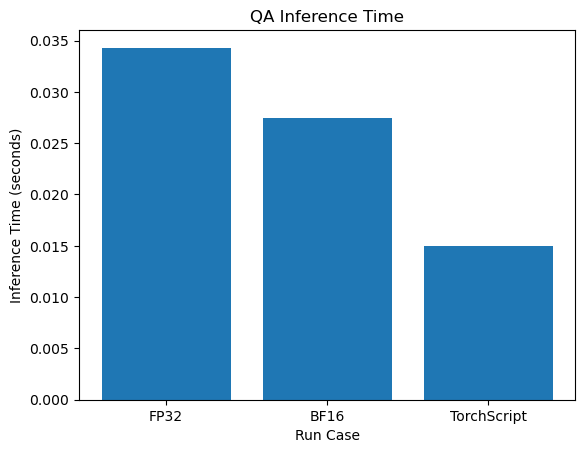

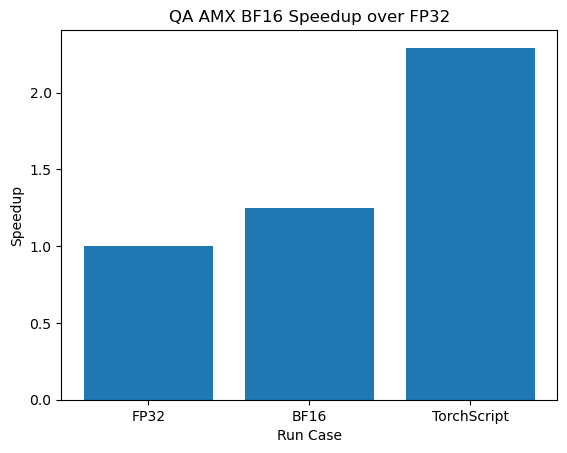

In [12]:
# Summarize and display results
#!pip install matplotlib
import matplotlib.pyplot as plt
results_bert = {
        "FP32": fp32_inference_time,
        "BF16": bf16_inference_time,
        "TorchScript": torchscript_inference_time
    }
summarize_results("QA", results_bert)
plt.show()